In [10]:
from css_code import toric_code_matrices
import matplotlib.pyplot as plt
import numpy as np
from ldpc import BpDecoder, BpOsdDecoder
from decoder_performance import compute_logical_error_rate

# compare between BP and BP+OSD decoders with different distances of the toric code

distances = [9, 11, 13, 15]
error_rates = np.linspace(0.01, 0.13, 13)  # Error rates from 0.01 to 0.1
max_iter = 60
ms_scaling_factor = 0.625
osd_order = 60  # Order of the OSD method
run_count = 100000 # Number of runs for each error rate
logical_error_rates_bp = []
logical_error_rates_bp_osd = []

for d in distances:
    print(f"Distance: {d}")
    logical_error_rates_bp_with_d = []
    logical_error_rates_bp_osd_with_d = []
    Hx, Hz, Lx, Lz = toric_code_matrices(d)
    # remove the last row of Hx and Hz
    Hx = Hx[:-1, :]
    Hz = Hz[:-1, :]
    # H = vstack([Hx, Hz])

    for p in error_rates:
        # Initialize the BP decoder
        bp_decoder = BpDecoder(
        pcm=Hz,
        error_rate=float(p),
        max_iter=max_iter,
        ms_scaling_factor=ms_scaling_factor,
        schedule='parallel',
        )

        logical_error_rate_bp = compute_logical_error_rate(
            Hz, Lz, p, run_count=run_count, DECODER=bp_decoder, run_label=f"BP (d={d}, p={p})"
        )
        logical_error_rates_bp_with_d.append(logical_error_rate_bp)

        bp_osd_decoder = BpOsdDecoder(
            pcm=Hz,
            error_rate=float(p),
            max_iter=max_iter,
            ms_scaling_factor=ms_scaling_factor,
            schedule='parallel',
            osd_method='OSD_CS',
            osd_order=osd_order,
        )
        logical_error_rate_bp_osd = compute_logical_error_rate(
            Hz, Lz, p, run_count=run_count, DECODER=bp_osd_decoder, run_label=f"BP+OSD (d={d}, p={p})"
        )
        logical_error_rates_bp_osd_with_d.append(logical_error_rate_bp_osd)
    
    logical_error_rates_bp.append(logical_error_rates_bp_with_d)
    logical_error_rates_bp_osd.append(logical_error_rates_bp_osd_with_d)


Distance: 9
Decoder BP (d=9, p=0.01) finished in 9.16 seconds with 4473 failures out of 100000 runs.
Logical error rate for BP (d=9, p=0.01): 0.0447
Decoder BP+OSD (d=9, p=0.01) finished in 17.70 seconds with 0 failures out of 100000 runs.
Logical error rate for BP+OSD (d=9, p=0.01): 0.0000
Decoder BP (d=9, p=0.02) finished in 18.41 seconds with 15822 failures out of 100000 runs.
Logical error rate for BP (d=9, p=0.02): 0.1582
Decoder BP+OSD (d=9, p=0.02) finished in 48.18 seconds with 1 failures out of 100000 runs.
Logical error rate for BP+OSD (d=9, p=0.02): 0.0000
Decoder BP (d=9, p=0.03) finished in 30.57 seconds with 30889 failures out of 100000 runs.
Logical error rate for BP (d=9, p=0.03): 0.3089
Decoder BP+OSD (d=9, p=0.03) finished in 90.08 seconds with 48 failures out of 100000 runs.
Logical error rate for BP+OSD (d=9, p=0.03): 0.0005
Decoder BP (d=9, p=0.04) finished in 39.88 seconds with 42580 failures out of 100000 runs.
Logical error rate for BP (d=9, p=0.04): 0.4258
Deco

Logical error rates for BP decoders:
[[0.04473, 0.15822, 0.30889, 0.4258, 0.58119, 0.70382, 0.81179, 0.88238, 0.93223, 0.96395, 0.98196, 0.99248, 0.99651], [0.06531, 0.22492, 0.42145, 0.56267, 0.7314, 0.84031, 0.91587, 0.95816, 0.98177, 0.99257, 0.99765, 0.999, 0.99977], [0.08964, 0.29975, 0.53295, 0.69054, 0.83984, 0.92284, 0.96836, 0.98831, 0.996, 0.99894, 0.9998, 0.99999, 0.99997], [0.11736, 0.37777, 0.63505, 0.79321, 0.91607, 0.96835, 0.99052, 0.99724, 0.99949, 0.9999, 0.99996, 0.99999, 1.0]]
Logical error rates for BP+OSD decoders:
[[0.0, 1e-05, 0.00048, 0.00204, 0.00772, 0.0217, 0.04839, 0.09087, 0.14969, 0.22089, 0.30541, 0.38615, 0.46269], [0.0, 0.0, 8e-05, 0.00082, 0.00452, 0.0145, 0.03651, 0.07823, 0.14038, 0.22135, 0.31154, 0.40555, 0.49273], [0.0, 0.0, 3e-05, 0.00027, 0.00199, 0.00848, 0.0273, 0.06491, 0.12955, 0.21547, 0.32355, 0.42399, 0.51609], [0.0, 0.0, 0.0, 0.00014, 0.00121, 0.00579, 0.02005, 0.05523, 0.12041, 0.21702, 0.32772, 0.44166, 0.5407]]


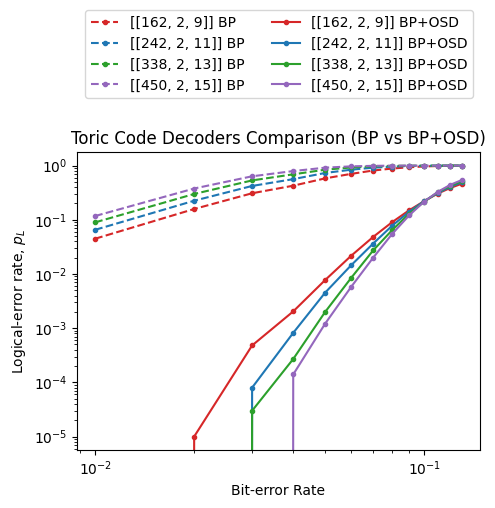

In [37]:
print("Logical error rates for BP decoders:")
print(logical_error_rates_bp)
print("Logical error rates for BP+OSD decoders:")
print(logical_error_rates_bp_osd)

colors = {
    9: 'tab:red',
    11: 'tab:blue',
    13: 'tab:green',
    15: 'tab:purple'
}

plt.figure(figsize=(5, 6))
plt.title("Toric Code Decoders Comparison (BP vs BP+OSD)")
plt.xlabel("Bit-error Rate")
plt.ylabel(r"Logical-error rate, $p_L$")
plt.xscale('log')
plt.yscale('log')

# Use different loop variables to avoid overwriting
for d, bp_vals in zip(distances, logical_error_rates_bp):
    # if d == 9 or d == 11:
    #     continue
    plt.plot(
        error_rates, bp_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP",
        marker='.',
        linestyle='--',
        color=colors[d]
    )

for d, bp_osd_vals in zip(distances, logical_error_rates_bp_osd):
    plt.plot(
        error_rates, bp_osd_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP+OSD",
        marker='.',
        linestyle='-',
        color=colors[d]
    )

# plt.plot(error_rates, error_rates, label="p_L = p", linestyle=':', color='black')

plt.legend(bbox_to_anchor=(1, 1.5), ncol=2)
plt.tight_layout()
plt.show()


Finding threshold for BP decoders: [[0.04473, 0.15822, 0.30889, 0.4258, 0.58119, 0.70382, 0.81179, 0.88238, 0.93223, 0.96395, 0.98196, 0.99248, 0.99651], [0.06531, 0.22492, 0.42145, 0.56267, 0.7314, 0.84031, 0.91587, 0.95816, 0.98177, 0.99257, 0.99765, 0.999, 0.99977], [0.08964, 0.29975, 0.53295, 0.69054, 0.83984, 0.92284, 0.96836, 0.98831, 0.996, 0.99894, 0.9998, 0.99999, 0.99997], [0.11736, 0.37777, 0.63505, 0.79321, 0.91607, 0.96835, 0.99052, 0.99724, 0.99949, 0.9999, 0.99996, 0.99999, 1.0]]
Finding threshold for BP+OSD decoders: [[0.0, 1e-05, 0.00048, 0.00204, 0.00772, 0.0217, 0.04839, 0.09087, 0.14969, 0.22089, 0.30541, 0.38615, 0.46269], [0.0, 0.0, 8e-05, 0.00082, 0.00452, 0.0145, 0.03651, 0.07823, 0.14038, 0.22135, 0.31154, 0.40555, 0.49273], [0.0, 0.0, 3e-05, 0.00027, 0.00199, 0.00848, 0.0273, 0.06491, 0.12955, 0.21547, 0.32355, 0.42399, 0.51609], [0.0, 0.0, 0.0, 0.00014, 0.00121, 0.00579, 0.02005, 0.05523, 0.12041, 0.21702, 0.32772, 0.44166, 0.5407]]
Checking error rate 0.01: 

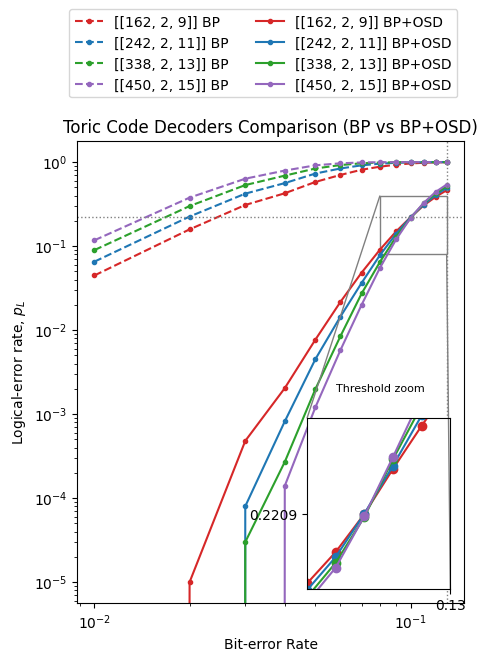

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

colors = {
    9: 'tab:red',
    11: 'tab:blue',
    13: 'tab:green',
    15: 'tab:purple'
}

def find_threshold(error_rates, logical_error_rates, distances, sort_reverse=True):
    """
    Find the estimated threshold point where increasing code distance 
    no longer decreases logical error rate.
    
    Returns:
        threshold_p (float): Bit-error rate at estimated threshold
        threshold_val (float): Logical error rate for lowest distance at threshold
    """
    for i in range(len(error_rates)):
        values_at_p = [row[i] for row in logical_error_rates]

        threshold_p = []
        threshold_val = []
        print(f"Checking error rate {error_rates[i]}: {values_at_p}")
        if values_at_p != sorted(values_at_p, reverse=sort_reverse):
            threshold_p.append(error_rates[i])
            threshold_val.append(logical_error_rates[0][i])  # value for smallest d
            print(f"Threshold found at p = {error_rates[i]}, value = {logical_error_rates[0][i]}")

    if threshold_p:
        return threshold_p[0], threshold_val[0]
    return None, None  # No threshold found

print(f"Finding threshold for BP decoders: {logical_error_rates_bp}")
print(f"Finding threshold for BP+OSD decoders: {logical_error_rates_bp_osd}")
threshold_bp, threshold_val_bp = find_threshold(error_rates, logical_error_rates_bp, distances, sort_reverse=False)
print(f"Threshold BP: {threshold_bp}, Logical error rate: {threshold_val_bp}\n")
threshold_bp_osd, threshold_val_osd = find_threshold(error_rates, logical_error_rates_bp_osd, distances, sort_reverse=True)
print(f"Threshold BP+OSD: {threshold_bp_osd}, Logical error rate: {threshold_val_osd}")


fig, ax = plt.subplots(figsize=(5, 6))
ax.set_title("Toric Code Decoders Comparison (BP vs BP+OSD)")
ax.set_xlabel("Bit-error Rate")
ax.set_ylabel(r"Logical-error rate, $p_L$")
ax.set_xscale('log')
ax.set_yscale('log')

for d, bp_vals in zip(distances, logical_error_rates_bp):
    ax.plot(
        error_rates, bp_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP",
        marker='.',
        linestyle='--',
        color=colors[d]
    )

for d, bp_osd_vals in zip(distances, logical_error_rates_bp_osd):
    ax.plot(
        error_rates, bp_osd_vals,
        label=f"[[{2 * d**2}, 2, {d}]] BP+OSD",
        marker='.',
        linestyle='-',
        color=colors[d]
    )

# Add vertical line at threshold
ax.axvline(threshold_bp_osd, color='gray', linestyle=':', linewidth=1)
# Add horizontal line at threshold
plt.axhline(threshold_value, color='gray', linestyle=':', linewidth=1)

# Add zoomed inset
axins = inset_axes(ax, width="37%", height="37%", loc='lower right', borderpad=1)
axins.set_xlim(0.08, 0.13)  # Adjust x-limits to zoom into threshold
axins.set_ylim(0.08, 0.4)     # Adjust y-limits to match threshold region
axins.set_xticks([threshold_bp_osd])
axins.set_yticks([threshold_value])

for d, bp_vals in zip(distances, logical_error_rates_bp):
    axins.plot(error_rates, bp_vals, marker='o', linestyle='--', color=colors[d])

for d, bp_osd_vals in zip(distances, logical_error_rates_bp_osd):
    axins.plot(error_rates, bp_osd_vals, marker='o', linestyle='-', color=colors[d])

# Add rectangle connector lines between main plot and inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Add label to inset
axins.text(0.09, 0.45, "Threshold zoom", fontsize=8)

ax.legend(bbox_to_anchor=(1, 1.3), ncol=2)
plt.show()
